In [129]:
import torch
import glob
import os
from PIL import Image
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.preprocessing import normalize
from keras.utils import normalize, to_categorical
from sklearn.preprocessing import LabelEncoder
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

In [167]:
import torch.utils.data as data

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, test = False):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'images','*.png'))
        self.mask_files = []
        self.img = []
        self.mask = []
        self.test = test

        if not self.test:
            for img_path in self.img_files:
                self.mask_files.append(os.path.join(folder_path,'labels',os.path.basename(img_path.split(".")[0] + "_Annotation.png"))) 
        

    def __getall__(self):
        for each in self.img_files:
            self.img.append(normalize(cv2.imread(each, cv2.IMREAD_COLOR), axis = 1))
        if not self.test:
            for each in self.mask_files:
                self.mask.append(cv2.imread(each, 0))
            
            return torch.from_numpy(np.array(self.img)).permute(0,3,1,2).detach().numpy() , torch.from_numpy(np.array(self.mask)).permute(0,1,2).detach().numpy()
        else:
            return torch.Tensor(np.array(self.img)).permute(0,3,1,2).detach().numpy()

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_COLOR)
            label = cv2.imread(mask_path, 0)
            return torch.from_numpy(data).float().permute(2,0,1), torch.from_numpy(label).float().permute(0,1)

    def __len__(self):
        return len(self.img_files)

In [168]:
train_dataset = DataLoaderSegmentation(r"C:\\College\\Origin Health\\origin_health_role_challenge_dataset\\interview\\train")
val_dataset = DataLoaderSegmentation(r"C:\\College\\Origin Health\\origin_health_role_challenge_dataset\\interview\\val")
test_dataset = DataLoaderSegmentation(r"C:\\College\\Origin Health\\origin_health_role_challenge_dataset\\interview\\test", test = True)

torch.Size([3, 540, 800]) torch.Size([540, 800])
torch.Size([800, 540, 3])


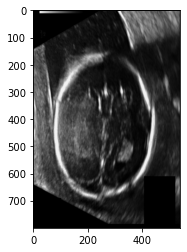

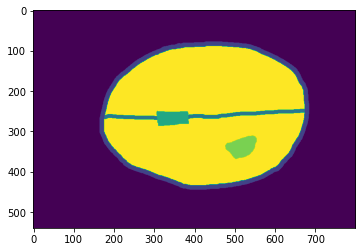

In [169]:
image, mask = train_dataset.__getitem__(5)
print(image.shape, mask.shape)
print(image.permute(2, 1, 0).shape)
plt.imshow(image.permute(2, 1, 0)/255)
plt.show()
plt.imshow(mask/255)
plt.show()

In [170]:
train_images, train_masks = train_dataset.__getall__()
val_images, val_masks = val_dataset.__getall__()
test_images = test_dataset.__getall__()

In [171]:
print(train_images.shape, train_masks.shape)
print(val_images.shape, val_masks.shape)
print(test_images.shape)

(59, 3, 540, 800) (59, 540, 800)
(10, 3, 540, 800) (10, 540, 800)
(13, 3, 540, 800)


In [172]:
print(np.unique(train_masks))

[0 1 2 3 4 5]


In [173]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [174]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Class weights are...: [ 0.27371275  3.39107528 20.60185747 38.07202137 19.47578593  0.51934778]


In [175]:
train_masks = np.expand_dims(train_masks, axis=3)
val_masks = np.expand_dims(val_masks, axis=3)
train_masks_cat = to_categorical(train_masks, num_classes = 6)
val_masks_cat = to_categorical(val_masks, num_classes = 6)
print(train_masks.shape)
print(val_masks.shape)
print(train_masks_cat.shape)
print(val_masks_cat.shape)

(59, 540, 800, 1)
(10, 540, 800, 1)
(59, 540, 800, 6)
(10, 540, 800, 6)


In [176]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=6, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [177]:
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [178]:
EPOCHS = 10

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])


In [179]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [180]:
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = False)
val_dataloader = DataLoader(val_dataset, batch_size = 16, shuffle = False)

In [181]:
def expanddims_n_tocategorical(x):
    #x = x.unsqueeze(1)
    x = torch.from_numpy(to_categorical(x.detach().numpy(), num_classes= 6))
    return x.permute(0,3,1,2)

torch.Size([3, 540, 800]) torch.Size([6, 540, 800])
torch.Size([540, 800, 3])


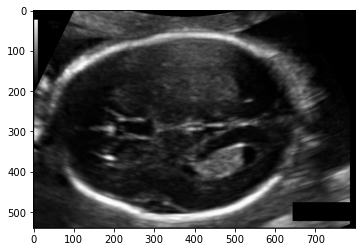

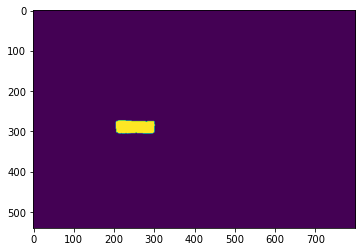

In [184]:
images, labels = next(iter(train_dataloader))
labels = expanddims_n_tocategorical(labels)
print(images[0].shape, labels[0].shape)
print(images[0].permute(1,2,0).shape)
plt.imshow(images[0].permute(1,2,0)/255)
plt.show()
plt.imshow(labels[0][3]/255)
plt.show()

In [ ]:
for epoch in range(EPOCHS):
    for each in train_dataloader:
        